# McKinsey Hackathon
(use data imputed with MICE ,validation AUC = 0.96)
(use data imputed with median and mode, validation AUC = 0.91)

## 6. Building Model to predict stroke probability

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
X_train_resampled = pd.read_csv('X_train_smoteenn.csv')
y_train_resampled = pd.read_csv('y_train_smoteenn.csv')
# double check if the data is correct
X_train_resampled.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3.0,0.0,0.0,95.12,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,58.0,1.0,0.0,87.96,39.2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,8.0,0.0,0.0,110.89,17.6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,70.0,0.0,0.0,69.04,35.9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,14.0,0.0,0.0,161.28,19.1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
y_train_resampled.head(5)

,stroke
0,0
1,0
2,0
3,0
4,0


# Scaling Variables

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X_train_resampled.as_matrix())
X_scaled = scaler.transform(X_train_resampled)

# Building Model

* *fit_and_roc* : the function to fit model using SVM, ANN or Random Forest
* *creat_baseline* : the function of building a multilayer perceptron using Keras

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import EarlyStopping

# baseline model
def create_baseline(n_features):
    # create model
    model = Sequential()
    model.add(Dense(2*n_features, input_dim=n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features//2, input_dim=2*n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features, input_dim=n_features//2, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fit_and_roc(name,x_train, y_train, x_valid, y_valid):
    # fit model using SVM, ANN or Random Forest
    # input name: string, specify the name of machine learning model to be applied
    #       x_train, y_train, x_valid, y_valid: dataframe for training and validation
    # output(the function will automaticlly plot AUC curve) model: a model object with "predict" function
    if name == "ann":
        n_features = x_train.shape[1]
        model = create_baseline(n_features)
        callback = EarlyStopping("val_loss", patience=1, verbose=0, mode='auto')
        model.fit(
                X_train, y_train,
                nb_epoch=20, batch_size=25,
                validation_data=(X_valid, y_valid),
                callbacks=[callback], verbose = 1)
    elif name == 'svm':
        model = svm.SVC(probability=True)
        model.fit(x_train, y_train)
    elif name == 'rf':
        model = RandomForestRegressor(n_jobs=2, n_estimators=150)
        model.fit(x_train, y_train)
    
    # evaluate training error
    y_train_pred = model.predict(x_train)
    y_train_prob = model.predict_proba(x_train)[:, 0]

    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label=1)
    if name == 'svm':
        fpr = 1-fpr
        tpr = 1-tpr
    roc_auc = auc(fpr, tpr)
    
    # evaluate testing error
    y_test_pred = model.predict(x_valid)
    y_test_prob = model.predict_proba(x_valid)[:, 0]
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_valid, y_test_prob, pos_label=1)
    if name == 'svm':
        fpr_test = 1-fpr_test
        tpr_test = 1-tpr_test
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # plot roc
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, \
             color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
    plt.plot(fpr_test, tpr_test, \
             color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return model

/Users/jessie/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_train_resampled['stroke'].values, random_state=666, train_size=0.80)

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/Users/jessie/anaconda3/lib/python3.5/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 61872 samples, validate on 15468 samples
Epoch 1/20
61872/61872 [==============================] - 9s 139us/step - loss: 0.4607 - acc: 0.7904 - val_loss: 0.3865 - val_acc: 0.8353
Epoch 2/20
61872/61872 [==============================] - 9s 148us/step - loss: 0.3857 - acc: 0.8286 - val_loss: 0.3750 - val_acc: 0.8326
Epoch 3/20
61872/61872 [==============================] - 9s 142us/step - loss: 0.3791 - acc: 0.8271 - val_loss: 0.3735 - val_acc: 0.8318
Epoch 4/20
61872/61872 [==============================] - 9s 142us/step - loss: 0.3758 - acc: 0.8260 - val_loss: 0.3684 - val_acc: 0.8296
Epoch 5/20
61872/61872 [==============================] - 8s 137us/step - loss: 0.3733 - acc: 0.8262 - val_loss: 0.3661 - val_acc: 0.8296
Epoch 6/20
61872/61872 [==============================] - 8s 131us/step - loss: 0.3706 - acc: 0.8277 - val_loss: 0.3630 - val_acc: 0.8325
Epoch 7/20
61872/61872 [==============================] - 8s 131us/step - loss: 0.3666 - acc: 0.8307 - val_loss: 0.3607 - 

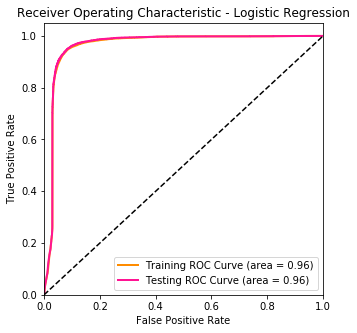

In [7]:
NN_model = fit_and_roc('ann',X_train, y_train, X_valid, y_valid)

# XGBoost

In [8]:
from xgboost import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [16]:
modelXGBoost = XGBClassifier() 
modelXGBoost.fit(X_train,y_train) # train 


y_train_prob = modelXGBoost.predict_proba(X_train)[:, 1]
y_valid_prob = modelXGBoost.predict_proba(X_valid)[:, 1] # validate with ROC curve
# note: [:, 0] because we only one possibility since the other is correlated

fpr, tpr, threshold = roc_curve(y_train, y_train_prob, pos_label=1)
fpr_test, tpr_test, threshold_test = roc_curve(y_valid, y_valid_prob, pos_label=1)

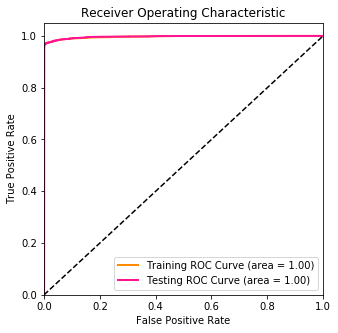

In [17]:
roc_auc = auc(fpr, tpr)
roc_auc_test = auc(fpr_test, tpr_test)

# plot ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, \
         color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
plt.plot(fpr_test, tpr_test, \
         color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## 7. Generate Test Result
Generate result for hackathon submission

In [37]:
df_test = pd.read_csv('processed_test.csv')

In [38]:
X_test = df_test.drop('id',1).as_matrix()
X_test_scaled = scaler.transform(X_test)

In [39]:
#result = NN_model.predict_classes(X_test_scaled)
result = NN_model.predict(X_test_scaled)

In [40]:
df_test['stroke'] = result

In [41]:
df_test.head(10)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,36306,80.0,0,0,83.84,21.1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0.899897
1,61829,74.0,0,1,179.50,26.0,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0.935180
2,14152,14.0,0,0,95.16,21.2,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0.004206
3,12997,28.0,0,0,94.76,23.4,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0.024291
4,40801,63.0,0,0,83.57,27.6,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0.539791
5,9348,66.0,1,0,219.98,32.2,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0.884979
6,51550,49.0,0,0,74.03,25.1,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0.376440
7,60512,46.0,0,0,120.80,32.5,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0.186525
8,31309,75.0,0,0,78.71,28.0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0.796326
9,39199,75.0,0,0,77.20,25.7,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0.901556


In [42]:
df_test[['id','stroke']].to_csv('result.csv',index = False)